# ERA 5 Preprocessing

## Imports:

In [5]:
from matplotlib import pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import re
import xarray as xr
import warnings
import re
import seaborn as sns

warnings.filterwarnings("ignore")

from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.era5land_preprocess import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

# set seed:
SEED = 5
seed_all(SEED)

## Pre-processing:
### MB data:

In [7]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes:', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# columns of interest in glamos data:
coi = [
    'vaw_id', 'sgi_id', 'rgi_id', 'glims_id', 'date_fix0', 'date_fix1', 'lat',
    'lon', 'height', 'b_a_fix', 'b_w_fix', 'aspect', 'slope', 'dis_from_border'
]
# glacier names:
glaciers = list(glStakes.keys())

Total number of stakes: 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]


In [8]:
stakesAll = np.concatenate(list(glStakes.values()))
stakesAll = [x[:-7] for x in stakesAll]
stakesAll

['basodino_P5',
 'basodino_P8',
 'basodino_P10',
 'sanktanna_P3',
 'findelen_400',
 'findelen_1010',
 'findelen_200',
 'findelen_800',
 'adler_200',
 'tsanfleuron_P6',
 'tsanfleuron_P2',
 'gries_P32',
 'gries_P112',
 'rhone_P8',
 'rhone_P4',
 'rhone_P2',
 'schwarzberg_P2',
 'aletsch_P5',
 'aletsch_P0',
 'aletsch_P9',
 'aletsch_P11',
 'aletsch_P10',
 'aletsch_P3',
 'limmern_P2',
 'limmern_P1',
 'limmern_P3',
 'pizol_P2',
 'pizol_P1',
 'plainemorte_P1',
 'clariden_U',
 'clariden_L',
 'allalin_P1',
 'silvretta_P9',
 'silvretta_BO',
 'silvretta_BU',
 'hohlaub_P2',
 'pers_P24',
 'pers_P39',
 'murtel_P3',
 'murtel_P1',
 'corbassiere_B2',
 'plattalva_P10',
 'plattalva_P11',
 'gietro_P1',
 'gietro_P3',
 'gietro_P5']

In [9]:
stakes20Years = ['basodino_P5',
 'basodino_P8',
 'basodino_P10',
 'gries_P32',
 'gries_P112',
 'schwarzberg_P2',
 'aletsch_P5',
 'aletsch_P0',
 'aletsch_P9',
 'aletsch_P11',
 'aletsch_P10',
 'aletsch_P3',
 'limmern_P2',
 'limmern_P1',
 'limmern_P3',
 'clariden_U',
 'clariden_L',
 'allalin_P1',
 'silvretta_P9',
 'silvretta_BO',
 'silvretta_BU',
 'hohlaub_P2',
 'pers_P24',
 'corbassiere_B2',
 'plattalva_P10',
 'plattalva_P11',
 'gietro_P1',
 'gietro_P3',
 'gietro_P5']

### ERA 5 Land monthly:
Create ERA5 xarrays for all stakes individually.

In [10]:
! ls ../../data/MB_modeling/ERA5/ERA5-Land/

ERA5-Land_10m-U-COMPONENT-WIND_MONTH_1950-2022.nc
ERA5-Land_10m-V-COMPONENT-WIND_MONTH_1950-2022.nc
ERA5-Land_2m-TEMPERATUR_MONTH_1950-2022.nc
ERA5-Land_FORECAST-ALBEDO_MONTH_1950-2022.nc
ERA5-Land_PRECIPITATION_MONTH_1950-2022.nc
ERA5-Land_SNOWDEPTH-WE_MONTH_1950-2022.nc
ERA5-Land_SNOWDEPTH_MONTH_1950-2022.nc
ERA5-Land_SURFACE-LATENT-HEAT-FLUX_MONTH_1950-2022.nc
ERA5-Land_SURFACE-NET-SOLAR-RADIATION_MONTH_1950-2022.nc
ERA5-Land_SURFACE-NET-THERMAL-RADIATION_MONTH_1950-2022.nc
ERA5-Land_SURFACE-PRESSURE_MONTH_1950-2022.nc
ERA5-Land_SURFACE-SENSIBLE-HEAT-FLUX_MONTH_1950-2022.nc
ERA5-Land_SURFACE-SOLAR-RADIATION-DOWNWARDS_MONTH_1950-2022.nc
ERA5-Land_SURFACE-THERMAL-RADIATION-DOWNWARDS_MONTH_1950-2022.nc
ERA5_PREC_MONTH_1979-2019.nc
ERA5_TEMP_DAY_2010-2018.nc
ERA5_TEMP_MONTH_1979-2019.nc
documentation.txt
geo_1279l4_0.1x0.1.grib2_v4_unpack.nc


In [12]:
# Example of one ERA5 Land file:
xr.open_dataset(
    '../../data/MB_modeling/ERA5/ERA5-Land/ERA5-Land_2m-TEMPERATUR_MONTH_1950-2022.nc'
)

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, expver: 2, time: 876)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2022-12-01
Data variables:
    t2m        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-02-16 13:09:41 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [13]:
%%time
era5landfiles = [
    f for f in listdir(path_ERA5_Land) if isfile(join(path_ERA5_Land, f))
    if (f[-2:] == 'nc') and ('ERA5-Land' in f)
]

era5landfiles = ["ERA5-Land_2m-TEMPERATUR_MONTH_1950-2022.nc", "ERA5-Land_PRECIPITATION_MONTH_1950-2022.nc"]

# Assemble ERA5 data for all stakes:
glaciers = list(glStakes.keys())
# create weekly ERA5
f = 'ERA5-Land_2m-TEMPERATUR_MONTH_1950-2022.nc'
era5_land = xr.open_dataset(path_ERA5_Land + f)
RUN = True
if RUN:
    emptyfolder(path_era5_stakes)
    emptyfolder(path_ERA5 + 'ERA5Land-stakes-hourly/')

    # Get all ERA5-land files
    era5landfiles = [
        f for f in listdir(path_ERA5_Land) if isfile(join(path_ERA5_Land, f))
        if (f[-2:] == 'nc') and ('ERA5-Land' in f)
    ]

    for fileName in tqdm(stakesAll):
            # Get coordinates and time of file for this stake:
            df_stake = read_stake_csv(path_glacattr, fileName+'_mb.csv')

            # Create corresponding ERA 5 xr
            stake_lat = df_stake.lat.unique()
            stake_lon = df_stake.lon.unique()
            stake_year0 = df_stake.date_fix0.iloc[0].year
            stake_year1 = df_stake.date_fix1.iloc[-1].year
            
            print(stake_year0, stake_year1)

            # create monthly ERA5 input
            xr_temppr, begin_xr, end_xr = createInputXR(
                era5landfiles, path_ERA5_Land, stake_lat, stake_lon,
                stake_year0, stake_year1)
            
            print(fileName, begin_xr, end_xr)

            # save to server:
            xr_temppr.to_netcdf(path_era5_stakes + f"{fileName}_mb_full.nc")
            # Pxr.to_netcdf(path_era5_stakes + f"{fileName}_full.nc")

            # Nearest neighbours of ERA5 to MB stake:
            P_ERA5 = era5_land.sel(latitude=stake_lat,
                                   longitude=stake_lon,
                                   method="nearest")
            era5_year0 = pd.to_datetime(P_ERA5["time"].values[0]).year
            era5_year1 = pd.to_datetime(P_ERA5["time"].values[-1]).year

            (begin, end) = findOverlapPeriod(stake_year0, stake_year1,
                                             era5_year0, era5_year1)

            if end == 2022:
                end = 2021

            for year in range(begin, end):
                 
                Ptemppr_weekly = createInputXR_weekly(year, stake_lat,
                                                      stake_lon, 
                                                      path_ERA5_Land_hourly)

                fileName_ = fileName + f'_{year}'

                Ptemppr_weekly.to_netcdf(path_ERA5 +
                                         'ERA5Land-stakes-hourly/' +
                                         f"{fileName_}.nc")
            del xr_temppr

  0%|          | 0/46 [00:00<?, ?it/s]

1991 2023
basodino_P5 1991 2022
1991 2023
basodino_P8 1991 2022
1991 2023


KeyboardInterrupt: 

In [ ]:
processed_stakes = [
    re.split('_', f)[0] + '_' + re.split('_', f)[1] for f in os.listdir(
        '../../data/MB_modeling/ERA5/ERA5Land-stakes-hourly/')
]
len(np.unique(processed_stakes))

29

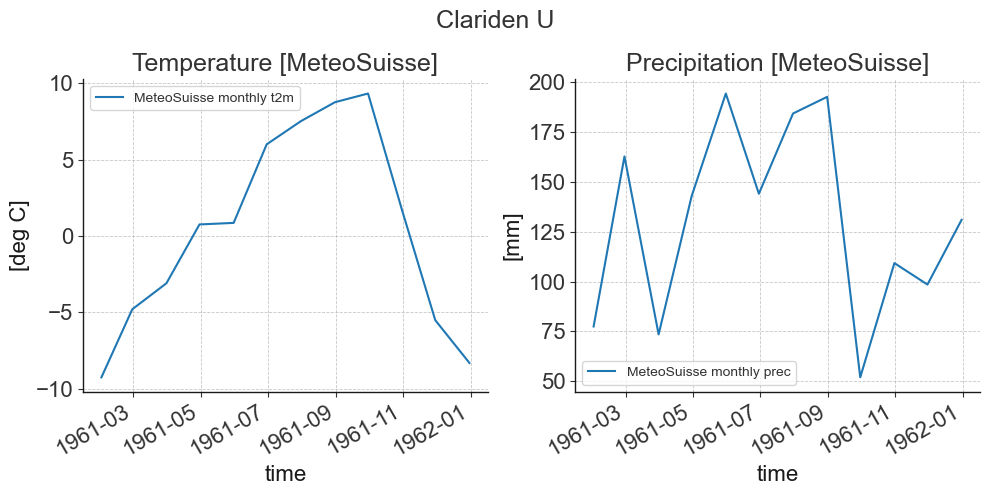

In [ ]:
# Example
Pxr_stake = xr.open_dataset(path_era5_stakes + f"clariden_U_mb_full.nc")
Pxr_stake_year = Pxr_stake.sel(
    time=pd.date_range('1961-01-31', '1961-12-31', freq='M'))

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
Pxr_stake_year.t2m.plot(ax=ax, label='MeteoSuisse monthly t2m')
ax.set_title(f'Temperature [{"MeteoSuisse"}]')
ax.set_ylabel('[deg C]')
ax.legend()

ax = plt.subplot(1, 2, 2)
Pxr_stake_year.tp.plot(ax=ax, label='MeteoSuisse monthly prec')

ax.set_title(f'Precipitation [{"MeteoSuisse"}]')
ax.set_ylabel('[mm]')
ax.legend()
plt.suptitle('Clariden U')
plt.tight_layout()